# Group 3 Project 4 - Collaborative Filtering (A1 vs A2 given P3)

## Kanyan Chen, Dingyi Fang, Yuhan Gong, Feichi Gu, Haoyu Zhang

## 11/21/2019

## Summary

These days we are constantly being recommended from various sources, such as suitable movies and popular music. **Collaborative Filtering** builds recommender system by analyzing relationships between users and interdependencies among items. One of methods to achieve Collaborative Filtering is **Latent Factor Models**.

Latent Factor Models characterizes both items and users on some factors inferred from the ratings patterns. This process is called **Matrix Factorization**. The major work of this project is to implement, evaluate and compare two matrix factorization techniques: **Stochastic Gradient Descent** (A1) and **Gradient Descent with Probabilistic Assumptions** (A2) based on RMSE and running time. To improve accuracy of factorization, we are assigned to use **kernel ridge regression** (P3) to postprocess previous SVD results. In this file, we will present our data preprocessing, algorithm implementation, evaluation results as well as some further discussions.

## Step 0:  Load packages and process data

### 0.1 load packages

In [0]:
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge

### 0.2 load and process data

In [0]:
## load rating data

from google.colab import files
import io
uploaded = files.upload()
Rate = pd.read_csv(io.BytesIO(uploaded['ratings.csv']))


#Rate = pd.read_csv("C:\\Users\\think\\Desktop\\project4\\ratings.csv")

## create dictionaries to relabel userId and movieId for future convenience
list_user = Rate.userId.unique()
dict_user = {}
for i in range(len(list_user)):
    dict_user[list_user[i]] = i
    
list_movie = Rate.movieId.unique()    
dict_movie = {}
for i in range(len(list_movie)):
    dict_movie[list_movie[i]]=i

## relabel original dataset with above ordinal number
for i in range(len(Rate)):
    Rate["userId"][i] = dict_user[Rate["userId"][i]]
    Rate["movieId"][i] = dict_movie[Rate["movieId"][i]]

## Train, Test split
# we split dataset by 9:1 rather than common 8:2 or 7:3 because of cold start problem
# If our training set is too sparse, then we cannot recommend anything if new movieId exist in testing set 
Train, Test = train_test_split(Rate, test_size = 0.1)

Train_user = list(Train["userId"])
Train_movie = list(Train["movieId"])
Train_rate = list(Train["rating"])

Test_user = list(Test["userId"])
Test_movie = list(Test["movieId"])
Test_rate = list(Test["rating"])


## Step 1:  implementing  A1 

### 1.1 Introduction about Algorithm

As mentioned in Paper 1, the concept of matrix factorization can be written mathematically as $\hat{\mathbf{R}}=\mathbf{Q}^\intercal \mathbf{P}$ where latent movie feature vector $Q$ and latent user feature vector $P$ are (k,m) and (k,n) matrices respectively.
Then we can create following objective function that we want to minimize with respect to $Q$ and $P:$ $\sum (r_{ui}-q_{i}^\intercal {p_{u}})^{2}+ \lambda ({\| q_{i}\|}^2+{\| p_{u}\|}^2)$. The term on the left is prediction error term. The term on the right is the regularization term. This is added since we do not want our decomposed matrix $Q$ and $P$ to overfit the observed data. 

One obvious method to find matrix $Q$ and $P$  is the ** Stochastic Gradient Descent** method. Since we have the loss function defined above, we can take the partial derivative respect to $q$ and $p$ to optimize existing values. The updating rule look like as below: 

$q_{i} \leftarrow q_{i} + \gamma \cdot(e_{ui} \cdot p_{u}-\lambda  \cdot q_{i})$

$p_{u} \leftarrow p_{u} + \gamma \cdot(e_{ui} \cdot q_{i}-\lambda  \cdot p_{u})$

In addition, to compare different algorithms and tune paramters, we mainly use measure Root Mean Square Error, the formula is as below:

$RMSE = \sqrt{\cfrac{1}{n} \cdot \sum({r_{ui}-\hat{r_{ui}})^2}} $

We create Python scripts to implement this algorithm:

In [0]:
## for A1, we use cross validation shown in 2.2 to find the optimal parameters: 
## factor = 15, lambda = 0.1, lr = 0.01  

def A1(Factor=20, Lambda=0.05, epochs=200, lr=0.01):
    ## set initial values for P & Q; history will show updating RMSE
    mu = (sum(Train_rate)/Factor/len(Train_rate))**.5
    P = np.random.normal(mu, .05, (len(list_user),Factor))
    Q = np.random.normal(mu, .05, (len(list_movie),Factor))
    history = np.zeros((epochs,2))
    last_change = 0

    for iteration in range(epochs):
        for i in range(len(Train)):
            
            ## find label or the ordinal for the user and movie
            user = Train_user[i] 
            movie = Train_movie[i] 
            error = Train_rate[i]-np.dot(Q[movie],P[user])
            temp = Q[movie]
            
            ## gradient descent
            Q[movie] = Q[movie] + lr*(error*P[user]-Lambda*Q[movie])
            P[user] = P[user] + lr*(error*temp-Lambda*P[user])
            
        ## calculate training and testing rmse after each epoch
        history[iteration,0] = (sum([(Train_rate[i]-np.dot(Q[Train_movie[i]],P[Train_user[i]]))**2 for i in range(len(Train))])/len(Train))**.5
        history[iteration,1] = (sum([(Test_rate[i]-np.dot(Q[Test_movie[i]],P[Test_user[i]]))**2 for i in range(len(Test))])/len(Test))**.5
        print(iteration,history[iteration,:])
        
        ## automatically change learning rate to avoid diverging
        if iteration-last_change>=30 and lr>0.0002:
            lr = lr * 0.4
            last_change = iteration
            print("learning rate change to ",lr)
    
    return P,Q,history

In [0]:
## show RMSE history for training and testing set based on A1; and calculate running time

start1 = timeit.default_timer()
result1 = A1(epochs=200)
stop1 = timeit.default_timer()

print('Running Time for A1: ', stop1 - start1, 's')

### 1.2 Parameter Tuning

In [0]:
'''
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from itertools import product
import multiprocessing
    
## Train Test split
K = 5
Train_list = []
kf = KFold(n_splits = K,shuffle = True)
for Train_index in kf.split(Rate):
    Train_list = Train_list + [Rate.iloc[Train_index]]
    
def Df_to_list(Train,Test):
    Train_user = list(Train["userId"])
    Train_movie = list(Train["movieId"])
    Train_rate = list(Train["rating"])
    Test_user = list(Test["userId"])
    Test_movie = list(Test["movieId"])
    Test_rate = list(Test["rating"])
    return Train_user,Train_movie,Train_rate,Test_user,Test_movie,Test_rate


def SGD_CV(pairs):
    factor = pairs[0]
    lambda_A1 = pairs[1]
    epochs = pairs[2]
    best_rmse = []
    for k in range(K):
        lr = pairs[3]
        P = np.random.normal(0, .1, (len(list_user),factor))
        Q = np.random.normal(0, .1, (len(list_movie),factor))
        Train_user, Train_movie, Train_rate, Validation_user, Validation_movie, Validation_rate = Df_to_list(Train_list[k],Validation_list[k])
        history = np.zeros((epochs,2))
        for _ in range(epochs):
            for i in range(len(Train_user)):
                user = Train_user[i]
                movie = Train_movie[i]
                error = Train_rate[i]-np.dot(Q[movie],P[user])
                temp = Q[movie]
                Q[movie] = Q[movie] + lr*(error*P[user]-lambda_A1*Q[movie])
                P[user] = P[user] + lr*(error*temp-lambda_A1*P[user])
                # calculate training and testing rmse after each epoch
            #history[_,0] = sum([(Train_rate[i]-np.dot(Q[Train_movie[i]],P[Train_user[i]]))**2 for i in range(len(Train_user))])/len(Train_user)
            #history[_,1] = sum([(Validation_rate[i]-np.dot(Q[Validation_movie[i]],P[Validation_user[i]]))**2 for i in range(len(Validation_user))])/len(Validation_user)
            #print(_,history[_,0],history[_,1])
            if _%30==0 and _>0 and lr>0.0001:
                lr = lr * 0.4
        best_rmse.append((sum([(Validation_rate[i]-np.dot(Q[Validation_movie[i]],P[Validation_user[i]]))**2 for i in range(len(Validation_user))])/len(Validation_user))**.5)
    return best_rmse,factor,lambda_A1,epochs,lr

if __name__ == '__main__':
    P = [[8,10,12,15,20],[0.05,0.1,0.15,0.2],[500],[0.01]] # Factor, lambda, epochs(should be 300, 20 is for testing only),learning rate 
    pairs = product(*P)
    pool = multiprocessing.Pool() # change the process amount based on your own CPU, default is using all Threads
    result = pool.map(SGD_CV, pairs)
    pool.close()
    pool.join()
    with open('A1.txt', 'w') as file:
        for i in result:
            file.writelines(str(sum(i[0])/K))
            file.writelines([str(t)+',' for t in i[1:]]+["\n"])
'''

## Step 2:   Implementing  A2

### 2.1 Introduction about Algorithm

In brief, Probabilistic Matrix Factorization is a simple probabilistic model with Gaussian observation
noise. Similar to A1, as indicated in Paper 2, we should minimize the sum-of-squared-errors objective function with respect to $Q$ and $P :$ $$\frac{1}{2} \sum_{i=1}^{N} \sum_{u=1}^{M} I_{ui}(r_{ui}-q_{i}^\intercal {p_{u}})^2 + \frac{\lambda_{q}}{2} \sum_{i=1}^{N}{\| q_{i}\|}^2 + \frac{\lambda_{p}}{2}\sum_{u=1}^{M}{\| p_{u}\|}^2$$

$I_{ui}$ is the indicator function that is equal to 1 if user $u$ rated movie $i$ and equal to 0 otherwise

We also use gradient descent to find local minimum of the above objective function. Scripts are as below:

In [0]:
## for A2, we use cross validation shown in 3.2 to find the optimal parameters: 
## factor = 5, Lambda_P = 0.1, Lambda_Q = 0.1, lr = 0.0001  

def A2(Factor=5, Lambda_P=0.1, Lambda_Q=0.1, epochs=500, lr=0.0001):
    mu = (sum(Train_rate)/Factor/len(Train_rate))**.5
    P = np.random.normal(mu, .05, (len(list_user),Factor))
    Q = np.random.normal(mu, .05, (len(list_movie),Factor))
    history = np.zeros((epochs,2))
    for iteration in range(epochs):
        Gradient_P = np.zeros((len(list_user),Factor))
        Gradient_Q = np.zeros((len(list_movie),Factor))
        
        for i in range(len(Train)):
            user = Train_user[i]
            movie = Train_movie[i]
            error = Train_rate[i]-np.dot(Q[movie],P[user])
            Gradient_P[user] += error * Q[movie] 
            Gradient_Q[movie] += error * P[user]
        for i in range(len(list_user)):
            Gradient_P[i] -= Lambda_P * P[i]
        for i in range(len(list_movie)):
            Gradient_Q[i] -= Lambda_Q * Q[i]
        P = P + lr*Gradient_P
        Q = Q + lr*Gradient_Q
        
        # calculate training and testing rmse after each epoch
        history[iteration,0] = (sum([(Train_rate[i]-np.dot(Q[Train_movie[i]],P[Train_user[i]]))**2 for i in range(len(Train))])/len(Train))**.5
        history[iteration,1] = (sum([(Test_rate[i]-np.dot(Q[Test_movie[i]],P[Test_user[i]]))**2 for i in range(len(Test))])/len(Test))**.5
        print(iteration,history[iteration])
    return P,Q,history


In [0]:
## show RMSE history for training and testing set based on A2; calculate running time

start2 = timeit.default_timer()
result2 = A2()
stop2 = timeit.default_timer()

print('Running Time for A1: ', stop2 - start2, 's')

### 2.2 Parameter Tuning

In [0]:
'''
def GD_CV(pairs):
    factor = pairs[0]
    Lambda_P = pairs[1]
    Lambda_Q = pairs[2]
    epochs = pairs[3]
    lr = pairs[4]
    best_rmse = []
    for k in range(K):
        lr = pairs[4]
        P = np.random.normal(0, .1, (len(list_user),factor))
        Q = np.random.normal(0, .1, (len(list_movie),factor))
        Train_user, Train_movie, Train_rate, Validation_user, Validation_movie, Validation_rate = Df_to_list(Train_list[k],Validation_list[k])
        history = np.zeros((epochs,2))
        for _ in range(epochs):
            Gradient_P = np.zeros((len(list_user),factor))
            Gradient_Q = np.zeros((len(list_movie),factor))
            for i in range(len(Train_user)):
                user = Train_user[i]
                movie = Train_movie[i]
                error = Train_rate[i]-np.dot(Q[movie],P[user])
                Gradient_P[user] += error * Q[movie] 
                Gradient_Q[movie] += error * P[user]
            for i in range(len(list_user)):
                Gradient_P[i] -= Lambda_P * P[i]
            for i in range(len(list_movie)):
                Gradient_Q[i] -= Lambda_Q * Q[i]
            P = P + lr*Gradient_P
            Q = Q + lr*Gradient_Q
            # calculate training and testing rmse after each epoch
            #history[_,0] = sum([(Train_rate[i]-np.dot(Q[Train_movie[i]],P[Train_user[i]]))**2 for i in range(len(Train_user))])/len(Train_user)
            #history[_,1] = sum([(Validation_rate[i]-np.dot(Q[Validation_movie[i]],P[Validation_user[i]]))**2 for i in range(len(Validation_user))])/len(Validation_user)
            
        best_rmse.append((sum([(Validation_rate[i]-np.dot(Q[Validation_movie[i]],P[Validation_user[i]]))**2 for i in range(len(Validation_user))])/len(Validation_user))**.5)
    return sum(best_rmse)/K,factor,Lambda_P,Lambda_Q,epochs,lr

#GD_CV([5,0.1,0.2,20,0.001])

if __name__ == '__main__':
    P = [[3,5,7,10],[0.1,0.2],[0.1,0.2],[300],[0.001]] # Factor, lambda_P, lambda_Q, epochs(should be 300, 20 is for testing only),learning rate 
    pairs = product(*P)
    pool = multiprocessing.Pool() # change the process amount based on your own CPU, default is using all Threads
    result = pool.map(GD_CV, pairs)
    pool.close()
    pool.join()
    print(result)
    with open('A2.txt', 'w') as file:
        for i in result:
            file.writelines([str(t)+',' for t in i]+["\n"])
'''

## Step 3:   Postprocessing

### 3.1 Introduction about Model

After matrix factorization, postprocessing will be performed to improve accuracy. Here we apply kernel ridge regression (P3) to previous SVD results. 

Commonly we will predict rating by $r_{ui}=q_{i}^\intercal {p_{u}}$. For P3, it discards all latent user feature vectors $P$ after training matrix factorization algorithms and try to predict rating for each user $u$ by fitting kernel ridge regression and using latent movie feature vector $Q$ as predictors. By changing Gram matrix, we can have different kernels. The Gaussian kernel in Paper 2 does not perform that well as we expect, so we change to ***rbf*** kernel and tune its parameter. 

In [0]:
## for A1 & A2, we will tune parameters separately

def KRR(Q,alpha=0.5,gamma=0.01):
    train_error = []
    test_error = []
    
    for i in Test.userId.unique():
        ## training set for user i
        y = []
        X = []
        
        ## testing set for user i
        X_test = []
        y_test = []
        
        ## remember we should normalize movie vectors  
        for j in range(len(Test)):
            if Test_user[j]==i:
                X_test.append(Q[Test_movie[j]]/np.linalg.norm(Q[Test_movie[j]]))
                y_test.append(Test_rate[j])
        for j in range(len(Train)):
            if Train_user[j]==i:
                X.append(Q[Train_movie[j]]/np.linalg.norm(Q[Train_movie[j]]))
                y.append(Train_rate[j])
        
        clf = KernelRidge(alpha = alpha, kernel = "rbf", gamma = gamma)
        clf.fit(X,y)
        y_estimate = clf.predict(X_test)
        y_train_estimate = clf.predict(X)
        train_error = train_error + [y[k] - y_train_estimate[k] for k in range(len(y))]
        test_error = test_error + [y_test[k] - y_estimate[k] for k in range(len(y_test))]
        
    print((sum([train_error[i]**2 for i in range(len(train_error))])/len(train_error))**.5)
    print((sum([test_error[i]**2 for i in range(len(test_error))])/len(test_error))**.5)
    return (sum([test_error[i]**2 for i in range(len(test_error))])/len(test_error))**.5

In [17]:
# show RMSE for A1P3 and calculate running time

start_13 = timeit.default_timer()
A1P3 = KRR(result1[1],alpha=0.5,gamma=0.1)
stop_13 = timeit.default_timer()

print('Running Time for A1P3: ', stop_13 - start_13, 's')

0.6406904196028844
0.8982856059265927
Running Time for A1P3:  43.12218872399899 s


In [23]:
# show RMSE for A2P3 and calculate running time

start_23 = timeit.default_timer()
A2P3 = KRR(result2[1],alpha=0.5,gamma=0.2)
stop_23 = timeit.default_timer()

print('Running Time for A2P3: ', stop_23 - start_23, 's')

0.9284085638595198
0.9379110179456425
Running Time for A2P3:  42.527320585999405 s


### 3.2 Parameter Tuning

In this step, we tune these two parameters for A1P3 and A2P3 by inputing different values combination rather than serious cross validation. Because cross validation will split datasets and thus require different optimal $Q$ vectors. To make it easier, we just leverage the optimal $Q$ vectors from step 1 and 2 and then try different parameters for P3 without cross validation. 


## Step 4:   Evaluation and Discussion

### 4.1 RMSE and Running Time Comparison

In [26]:
data = [[result1[2][199][0],result1[2][199][1],stop1-start1,A1P3,stop_13-start_13],[result2[2][499][0],result2[2][499][1],stop2-start2,A2P3,stop_23-start_23]]
algo_list=['A1','A2']
col_list = ['train RMSE','test RMSE','SVD time','P3 test RMSE','P3 time']
pd.DataFrame(data, algo_list, col_list)

,train RMSE,test RMSE,SVD time,P3 test RMSE,P3 time
A1,0.517245,0.856704,280.859396,0.898286,43.122189
A2,0.820165,0.859496,522.432323,0.937911,42.527321


Conclusion: A1 has lower test error and takes shorter time to process factorization than A2. A1 is more time-saving because A1 converges quickly and we set epoch value for A1 to be 200 while epoch for A2 is 500. In addition, P3 postprocessing seems to lose its power regarding improving accuracy on both algorithms. We think this may be reasonable because kernel ridge regression only utilize information in movie feature vectors and thus in some cases may not be a wise choice to improve performance of our recommender system.

### 4.2 Converging Performance Comparison

In [0]:
result1 = A1(epochs=500)

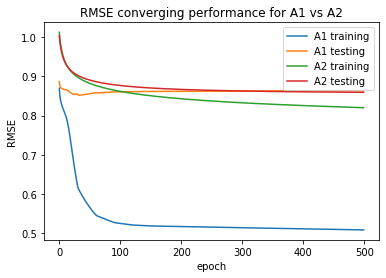

In [29]:
x = range(0,500)
plt.title('RMSE converging performance for A1 vs A2')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.plot(x, result1[2])
plt.plot(x, result2[2])
plt.legend(['A1 training','A1 testing','A2 training', 'A2 testing'], loc='upper right')

From above plot, we can tell that A1 converges faster than A2. In order to compare A1 and A2 in the same plot, we set epoch value of A1 to be 500 here. In addition, A1 has much lower training error than A2 and seems to have some overfitting problem. This is also reasonable because A1 has larger dimension of feature factors and somehow complex if the epoch value is the same as A2.

### 4.3 Future Discussion

How to set initial values for P and Q is an interesting subject. In the beginning stage of our project, we set values of P and Q equal to random number from Normal(0,0.1). This may cause many problems and result in larger RMSE because it assumes the expectation of $q_{i}^Tp_{u}$ is 0 before updating.

Therefore, to fix this issue, we set intial values that can somehow let the expectation of $q_{i}^Tp_{u}$ to be the mean of ratings in our training set.


In [0]:
#mu = (sum(Train_rate)/Factor/len(Train_rate))**.5) 
#P = np.random.normal(mu, .05, (len(list_user),Factor)) 
#Q = np.random.normal(mu, .05, (len(list_user),Factor)) 

This provides more prior information than random guesses and proves to improve the accuracy of our algorithms.


## Reference

P1: Yehuda Koren, Robert Bell, Chris Volinsky. Matrix Factorization Techniques For Recommender Systems. 

P3: Ruslan Salakhutdinov, Andriy Mnih. Probabilistic Matrix Factorization.

P2: Arkadiusz Paterek. Improving Regularized Singular Value Decomposition for Collaborative Filtering. 